## Visualize images on model without adaption

In order to investigate on which images the model performs good and on which images it performs bad, we visualize the images, GT and predicted density maps. Note that this shows images **WITHOUT ADAPTATION**.


In [1]:
import sys
sys.path.append("../")

In [2]:
data_folder = "data/"
im_folder = "images_384_VarV2"
gt_folder = "gt_density_map_adaptive_384_VarV2"

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

In [4]:
from model import CountRegressor, Resnet50FPN
from utils import Transform, MAPS, Scales, extract_features, MincountLoss, PerturbationLoss
import torch.optim as optim
import torch
import json
from tqdm import tqdm

In [5]:
class PredictNoAdaptation:
    
    def __init__(self, im_dir, pretrained_path, anno_file):
        self.resnet50_conv = Resnet50FPN()
        self.resnet50_conv.eval()

        self.regressor = CountRegressor(6, pool='mean')
        self.regressor.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu')))
        self.regressor.eval()
        
        self.im_dir = im_dir

        with open(anno_file) as f:
            self.annotations = json.load(f)

    def predict(self, im_id):
        anno = self.annotations[im_id]
        bboxes = anno['box_examples_coordinates']
        dots = np.array(anno['points'])

        rects = list()
        for bbox in bboxes:
            x1, y1 = bbox[0][0], bbox[0][1]
            x2, y2 = bbox[2][0], bbox[2][1]
            rects.append([y1, x1, y2, x2])

        image = Image.open('{}/{}'.format(self.im_dir, im_id))
        image.load()
        sample = {'image': image, 'lines_boxes': rects}
        sample = Transform(sample)
        image, boxes = sample['image'], sample['boxes']

        image = image
        boxes = boxes

        with torch.no_grad(): features = extract_features(self.resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)
        with torch.no_grad(): output = self.regressor(features)

        return output

In [21]:
class PredictWithAdaptation:
    
    def __init__(self, im_dir, pretrained_path, anno_file):
        self.resnet50_conv = Resnet50FPN()
        self.resnet50_conv.eval()
        self.resnet50_conv.cuda()

        self.regressor = CountRegressor(6, pool='mean')
        self.regressor.cuda()
        self.regressor.load_state_dict(torch.load(pretrained_path))
        self.regressor.eval()
        
        self.im_dir = im_dir

        with open(anno_file) as f:
            self.annotations = json.load(f)

    def predict(self, im_id):
        anno = self.annotations[im_id]
        bboxes = anno['box_examples_coordinates']
        dots = np.array(anno['points'])

        rects = list()
        for bbox in bboxes:
            x1, y1 = bbox[0][0], bbox[0][1]
            x2, y2 = bbox[2][0], bbox[2][1]
            rects.append([y1, x1, y2, x2])

        image = Image.open('{}/{}'.format(self.im_dir, im_id))
        image.load()
        sample = {'image': image, 'lines_boxes': rects}
        sample = Transform(sample)
        image, boxes = sample['image'], sample['boxes']

        image = image.cuda()
        boxes = boxes.cuda()

        with torch.no_grad(): features = extract_features(self.resnet50_conv, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)
        
        features.required_grad = True
        #adapted_regressor = copy.deepcopy(regressor)
        adapted_regressor = self.regressor
        adapted_regressor.train()
        optimizer = optim.Adam(adapted_regressor.parameters(), lr=1e-7)

        pbar = tqdm(range(100))
        for step in pbar:
            optimizer.zero_grad()
            output = adapted_regressor(features)
            lCount = 1e-9 * MincountLoss(output, boxes, use_gpu=True)
            lPerturbation = 1e-4 * PerturbationLoss(output, boxes, sigma=8, use_gpu=True)
            Loss = lCount + lPerturbation
            # loss can become zero in some cases, where loss is a 0 valued scalar and not a tensor
            # So Perform gradient descent only for non zero cases
            if torch.is_tensor(Loss):
                Loss.backward()
                optimizer.step()

            pbar.set_description('Adaptation step: {:<3}, loss: {}, predicted-count: {:6.1f}'.format(step, Loss.item(), output.sum().item()))

        features.required_grad = False
        output = adapted_regressor(features)
        output = output.cpu()
        return output

In [16]:
predictor = PredictNoAdaptation(os.path.join("../", data_folder, im_folder),
                               os.path.join("../", data_folder, "pretrainedModels", "FamNet_Save1.pth"),
                               os.path.join("../", data_folder, "annotation_FSC147_384.json"))

In [22]:
predictor_adapt = PredictWithAdaptation(os.path.join("../", data_folder, im_folder),
                               os.path.join("../", data_folder, "pretrainedModels", "FamNet_Save1.pth"),
                               os.path.join("../", data_folder, "annotation_FSC147_384.json"))

10 images with smallest relative absolute error on test set without adaptation
```
('4119.jpg', 2.47955322265625e-05), 
('2207.jpg', 0.00012502670288085937), 
('2241.jpg', 0.000411834716796875), 
('5938.jpg', 0.0010505184050529233), 
('309.jpg', 0.0018459083759679203), 
('4881.jpg', 0.00201263427734375), 
('7136.jpg', 0.002112202260686063), 
('5928.jpg', 0.0035333962276064114), 
('6044.jpg', 0.004016343937363736), 
('3336.jpg', 0.0040943357679579)
```
10 images with highest relative absolute error  on test set without adaptation
```
('6869.jpg', 2.84359623835637), 
('6266.jpg', 2.8620304780847885), 
('6245.jpg', 2.8686656951904297), 
('6.jpg', 2.9522103203667536), 
('4421.jpg', 3.070706844329834), 
('4885.jpg', 3.1824111938476562), 
('6842.jpg', 3.7049361334906683), 
('7676.jpg', 4.103789230872845), 
('5365.jpg', 7.4104724460177955), 
('7171.jpg', 48.82430795522836)
```

### Select image here

In [105]:
image_id = "5811"
image_name = f"{image_id}.jpg"
gt_name = f"{image_id}.npy"

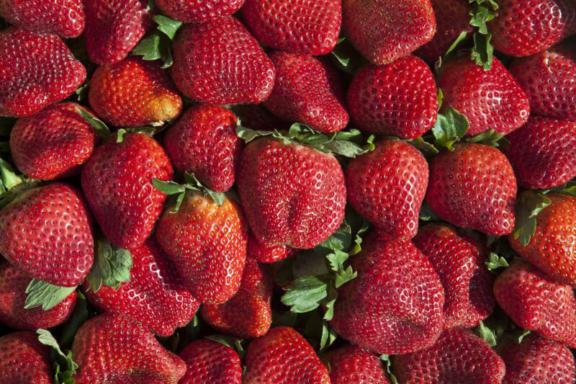

In [106]:
img = Image.open(os.path.join("../", data_folder, im_folder, image_name))
img

### Show GT

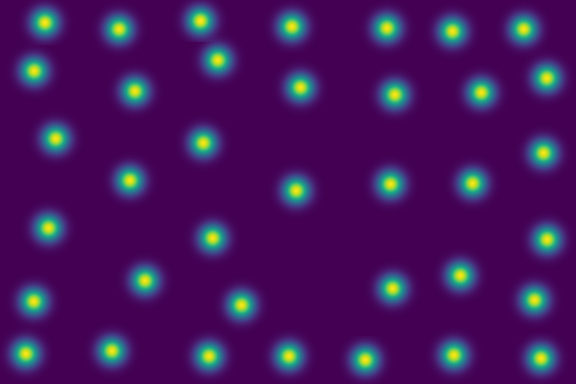

In [107]:
gt_map = np.load(os.path.join("../", data_folder, gt_folder, gt_name))
gt_map_image = Image.fromarray(np.uint8(cm.viridis(gt_map/np.max(gt_map))*255))
gt_map_image.save(f"visualizations/{image_id}_gt.png")
gt_map_image

### Show prediction without adaptation

In [108]:
output = predictor.predict(image_name)
output = output.numpy()[0, 0, :, :]


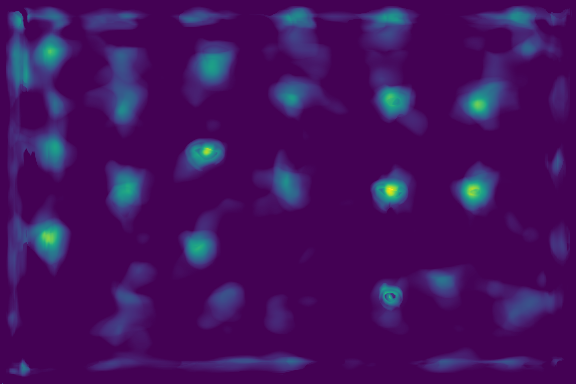

In [109]:
density_pred_image = Image.fromarray(np.uint8(cm.viridis(output/np.max(output))*255))
density_pred_image.save(f"visualizations/{image_id}_pred.png")
density_pred_image

### Show prediction with adaptation

In [110]:
output_adapt = predictor_adapt.predict(image_name)
output_adapt = output_adapt.detach().numpy()[0, 0, :, :]

Adaptation step: 99 , loss: 3.702080308976008e-11, predicted-count:   25.7: 100%|████| 100/100 [00:15<00:00,  6.38it/s]


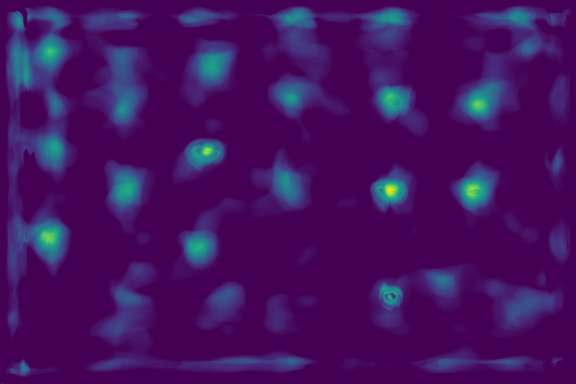

In [111]:
density_pred_adapt_image = Image.fromarray(np.uint8(cm.viridis(output_adapt/np.max(output_adapt))*255))
density_pred_adapt_image.save(f"visualizations/{image_id}_pred_adapt.png")
density_pred_adapt_image

### Save image in the correct shape to the same folder

In [112]:
img.resize(gt_map.shape[::-1])
img.save(f"visualizations/{image_id}_img.png")

In [113]:
count_gt, count_pred, count_pred_adapt = np.sum(gt_map), np.sum(output), np.sum(output_adapt)
print(f"GT: {count_gt}, Pred: {count_pred}, Pred: Abs error: {np.abs(count_gt - count_pred)}, Pred_adapt: {count_pred_adapt}, Pred_adapt: Abs error: {np.abs(count_gt - count_pred_adapt)}")

GT: 37.0, Pred: 22.16005516052246, Pred: Abs error: 14.839944839477539, Pred_adapt: 25.745952606201172, Pred_adapt: Abs error: 11.254047393798828
